In [ ]:
#Importamos librerias
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import tensorflow as tf
import keras
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

#Definimos una seed aleatoria
np.random.seed(42)
tf.random.set_seed(42)
keras.utils.set_random_seed(51)

Mounted at /content/drive


#CNN
### HIPERPARAMETROS
- Batch Size (Tamaño del Lote): Representa la cantidad de muestras que se procesan en cada paso de entrenamiento. Puede influir en la eficiencia del entrenamiento y el uso de memoria.
- Learning Rate (Tasa de Aprendizaje): Es un hiperparámetro que controla el tamaño de los ajustes durante el entrenamiento.
- Tamaño de los filtros (Kernels)
- Funciones de activación: funciones usadas para introducir no linealidades (ReLu, Sigmoid, Tanh)
- Algoritmo de optimización:
- Numero de epocas

### Métricas

1) Tiempo de Entrenamiento:

Indica cuánto tiempo lleva entrenar el modelo. Es relevante para evaluar la eficiencia computacional.

2) Curvas de Aprendizaje y Pérdida:

Representan visualmente cómo evolucionan la precisión y la pérdida a lo largo del tiempo de entrenamiento. Pueden ayudar a identificar problemas como sobreajuste o subajuste.

accuracy
f1


## Extracción de datos desde drive

In [ ]:
#Asignamos todos los paths de las carpetas a variables
#Datos de entrenamiento
train_pneumonia_dir = '/content/drive/Shareddrives/IA-Grupo4/5-CNN/ChestXRay/train/PNEUMONIA'
train_normal_dir = '/content/drive/Shareddrives/IA-Grupo4/5-CNN/ChestXRay/train/NORMAL'

# Datos de prueba
test_pneumonia_dir = '/content/drive/Shareddrives/IA-Grupo4/5-CNN/ChestXRay/test/PNEUMONIA'
test_normal_dir = '/content/drive/Shareddrives/IA-Grupo4/5-CNN/ChestXRay/test/NORMAL'

# Datos de validación
val_pneumonia_dir = '/content/drive/Shareddrives/IA-Grupo4/5-CNN/ChestXRay/val/PNEUMONIA'
val_normal_dir = '/content/drive/Shareddrives/IA-Grupo4/5-CNN/ChestXRay/val/NORMAL'


In [ ]:
# Extraer las imágenes de los paths y asignarlas a variables
# Datos de entrenamiento
train_pn = [os.path.join(train_pneumonia_dir, i) for i in os.listdir(train_pneumonia_dir)]
train_nn = [os.path.join(train_normal_dir, i) for i in os.listdir(train_normal_dir)]

# Datos de prueba
test_pn = [os.path.join(test_pneumonia_dir, i) for i in os.listdir(test_pneumonia_dir)]
test_nn = [os.path.join(test_normal_dir, i) for i in os.listdir(test_normal_dir)]

# Datos de validación
val_pn = [os.path.join(val_pneumonia_dir, i) for i in os.listdir(val_pneumonia_dir)]
val_nn = [os.path.join(val_normal_dir, i) for i in os.listdir(val_normal_dir)]

# Explorar el número total de imágenes
Total_images = len(train_pn + train_nn + test_pn + test_nn + val_pn + val_nn)
Total_pneumonia = len(train_pn + test_pn + val_pn)
Total_normal = len(train_nn + test_nn + val_nn)

print('El número total de imágenes es', Total_images)
print('El número total de imágenes de neumonía es', Total_pneumonia)
print('El número total de imágenes normales es', Total_normal)

train_set = train_pn + train_nn
test_set = test_pn + test_nn
val_set = val_pn + val_nn

El número total de imágenes es 5856
El número total de imágenes de neumonía es 4273
El número total de imágenes normales es 1583


In [ ]:
#Explore the pixel size of the images; open first image for the dataset
train_img = cv2.imread(train_set[0], cv2.IMREAD_GRAYSCALE)
test_img = cv2.imread(test_set[0], cv2.IMREAD_GRAYSCALE)
val_img = cv2.imread(val_set[0], cv2.IMREAD_GRAYSCALE)

train_height, train_width = train_img.shape
test_height, test_width = test_img.shape
val_height, val_width = val_img.shape

print('The pixel size of the 1st image in train set is', f"Width: {train_width} pixels", 'and', f"Height: {train_height} pixels")
print('The pixel size of the 1st image in test set is', f"Width: {test_width} pixels", 'and', f"Height: {test_height} pixels")
print('The pixel size of the 1st image in val set is', f"Width: {val_width} pixels", 'and', f"Height: {val_height} pixels")

The pixel size of the 1st image in train set is Width: 1088 pixels and Height: 736 pixels
The pixel size of the 1st image in test set is Width: 1024 pixels and Height: 688 pixels
The pixel size of the 1st image in val set is Width: 1192 pixels and Height: 952 pixels


In [ ]:
#Preprocessing
#Create a function to assign the images to their respective labels(Normal = 0; Pneumonia = 1), to resize the images to 128 x 128, to normalize the image
def preprocess_image(image_list, new_size=(224, 224)):

    X = []  # images
    y = []  # labels

    for image in image_list:
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        img_resized = cv2.resize(img, new_size)
        img_normalize = img_resized.astype(np.float32)/255.0
        X.append(img_normalize)


        if 'NORMAL' in image:
           y.append(0)
        elif 'IM' in image:
           y.append(0)
        elif 'virus' in image or 'bacteria' in image:
           y.append(1)
        else:
            print(f"Warning: Unable to load image {image}")

    return X, y

In [ ]:
#Preprocess the train, test and val dataset
X,y = preprocess_image(train_set)
A,b = preprocess_image(test_set)
C,d = preprocess_image(val_set)

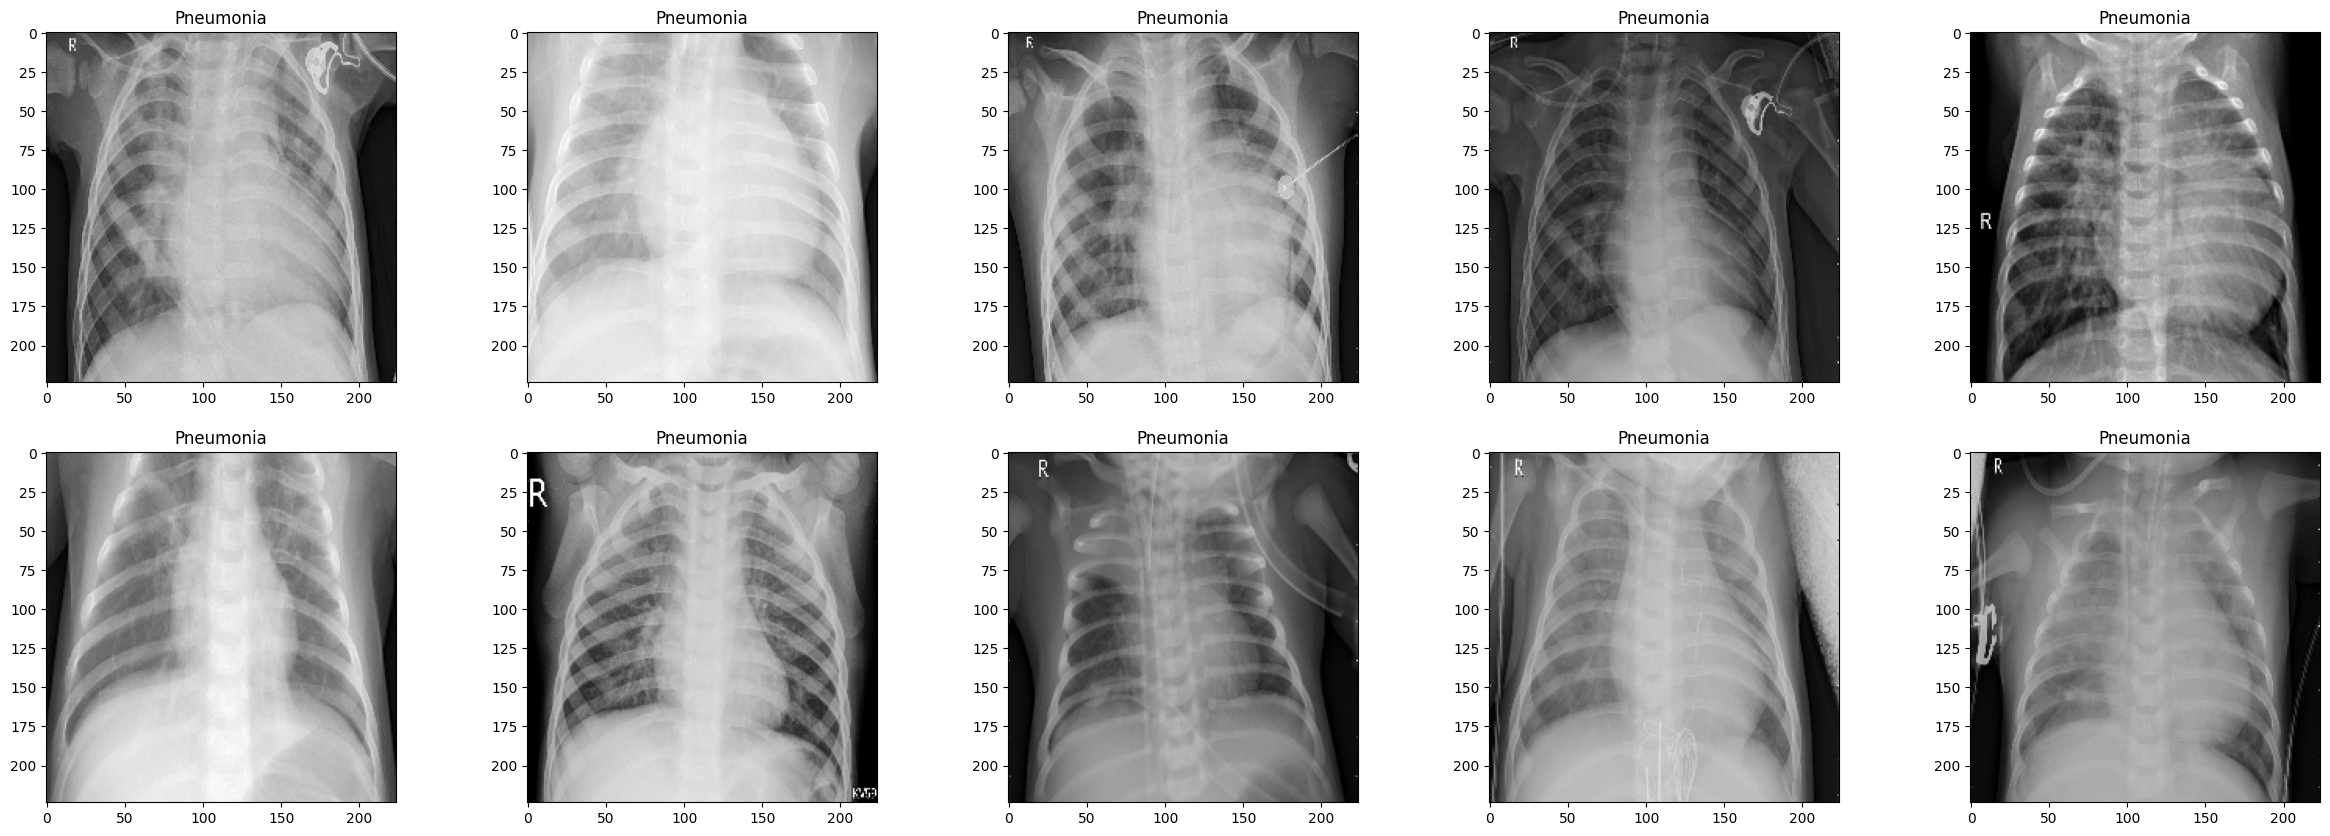

In [ ]:
#Visualize the images in the train set
fig = plt.figure(figsize=(30, 10))
fig.subplots_adjust(hspace=0.2)
k=1
for i in range(10):
    a = fig.add_subplot(2, 5, k)
    if (y[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')

    plt.imshow(X[i], cmap='gray')
    k=k+1;

In [ ]:
#Create a CNN model - BASELINE MODEL
#Import necessary library
import tensorflow as tf
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.layers import Dropout
from tensorflow.keras.losses import binary_crossentropy

In [ ]:
#Define the CNN architecture - 3 ConV layers(32, 64, 128 filters; 3x3) using ReLU activation function, 3 MaxPool layers(2x2),
#                              1 drropout layer, 1 FC layer 256 neurons, and output layer using sigmoid function
main_model = models.Sequential()

main_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1))) #tamano de kernls de 3x3 , con una capa convolucional de 32 filtos.

main_model.add(layers.MaxPooling2D((2, 2)))

main_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

main_model.add(layers.MaxPooling2D((2, 2)))  #capas hidden

main_model.add(layers.Conv2D(128, (3, 3), activation='relu'))

main_model.add(layers.MaxPooling2D((2, 2)))  #El MaxPooling se basa en recorrer cada una de las imágenes con matrices más pequeñas (por ej 2x2)
#y quedarse sólo con el valor más alto de ese grupo, reduciendo la dimensionalidad de la imagen.

main_model.add(Dropout(0.5))  # La capa de dropout ayuda a prevenir el sobreajuste al "apagar" aleatoriamente un porcentaje de las neuronas durante el entrenamiento

main_model.add(layers.Flatten())

main_model.add(layers.Dense(256, activation=  'relu'))# Esta línea crea una capa densamente conectada (totalmente conectada) con 256 neuronas.

main_model.add(layers.Dense(1,  activation = 'sigmoid'))

In [ ]:
main_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,244,353 (84.86 MB)

 Trainable params: 22,244,353 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Compile the model
main_model.compile(optimizer='adam', loss= binary_crossentropy, metrics=['accuracy'])

#Convert the dataset into numpy array as the fit() expects an numpy array
X_train = np.array(X)
y_train = np.array(y)
X_test = np.array(A)
y_test = np.array(b)
X_val = np.array(C)
y_val = np.array(d)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(5216, 224, 224)
(5216,)
(624, 224, 224)
(624,)
(16, 224, 224)
(16,)


In [ ]:
# Set a random seed for reproducibility
np.random.seed(10)

#Train the model
model_history = main_model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.7645 - loss: 0.6670 - val_accuracy: 0.6875 - val_loss: 0.6366
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9506 - loss: 0.1220 - val_accuracy: 0.7500 - val_loss: 0.3665
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9678 - loss: 0.0906 - val_accuracy: 0.6875 - val_loss: 0.5232
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9720 - loss: 0.0856 - val_accuracy: 0.8125 - val_loss: 0.2576
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9739 - loss: 0.0723 - val_accuracy: 1.0000 - val_loss: 0.1062
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9822 - loss: 0.0576 - val_accuracy: 0.9375 - val_loss: 0.1608
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9785 - loss: 0.0649 - val_accuracy: 1.0000 - val_loss: 0.0625
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9817 - loss: 0.0594 - val

In [ ]:
#Calculate the confusion matrix and performance matrix
#Import necessary library
from sklearn.metrics import accuracy_score, confusion_matrix

#Print out the confusion matrix and performance matrix
preds = main_model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))

tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\n============TEST METRICS=============')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
CONFUSION MATRIX ------------------
[[ 87 147]
 [  3 387]]

============TEST METRICS=============
Accuracy: 75.96153846153845%
Precision: 72.47191011235955%
Recall: 99.23076923076923%
F1-score: 83.76623376623377


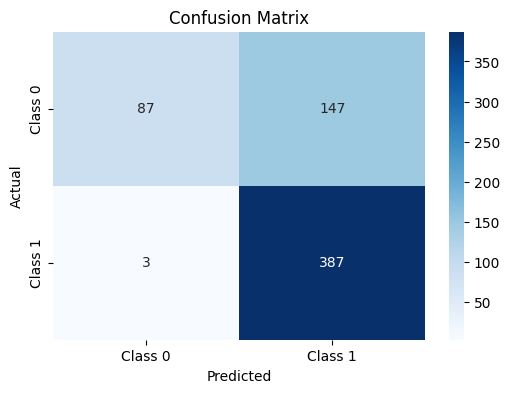

In [ ]:
#Plot the confusion matrix
#Import necessary library
import seaborn as sns
# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
class_names = ['Class 0', 'Class 1']
plot_confusion_matrix(cm, class_names)

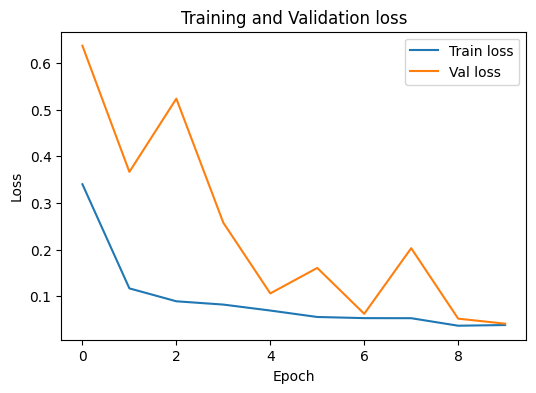

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(6, 4))
plt.plot(model_history.history['loss'], label='Train loss')
plt.plot(model_history.history['val_loss'], label='Val loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

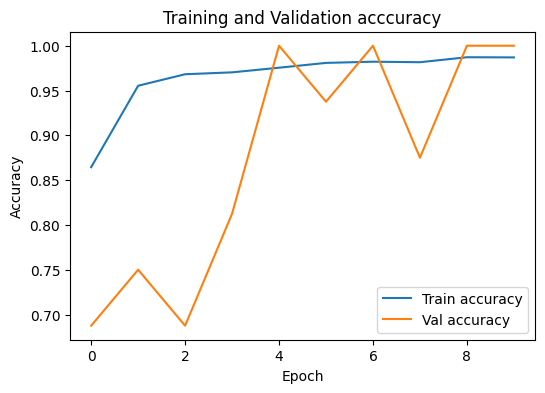

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(model_history.history['accuracy'], label='Train accuracy')
plt.plot(model_history.history['val_accuracy'], label='Val accuracy')
plt.title('Training and Validation acccuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def calculate_metrics(y_true, y_pred_classes):
    try:
        # Calcular métricas de rendimiento
        accuracy = accuracy_score(y_true, y_pred_classes) * 100
        precision = precision_score(y_true, y_pred_classes, average='weighted') * 100
        recall = recall_score(y_true, y_pred_classes, average='weighted') * 100
        f1 = f1_score(y_true, y_pred_classes, average='weighted')

        # Mostrar resultados
        print('============ TEST METRICS ============')
        print(f'Accuracy: {accuracy:.2f}%')
        print(f'Precision: {precision:.2f}%')
        print(f'Recall: {recall:.2f}%')
        print(f'F1 Score: {f1:.4f}')

        # Reporte de clasificación
        report = classification_report(y_true, y_pred_classes)
        print("\nClassification Report:")
        print(report)
    except Exception as e:
        print("An error occurred:", e)
